In [1]:
import numpy as np

# Data Extraction
import pandas as pd

# Machine Learning
import tensorflow as tf
import sklearn

# Helper Functions

### Fetch Clean Data

In [2]:
def fetch_data(data_path):
    
    df = pd.read_csv(clean_data_path, sep=',', encoding='ISO-8859-1', header=None)
    clean_data = np.array(df)

    # get rid of rows containing "nan" in clean data file
    rows_to_delete = []
    for i, row in enumerate(clean_data):
        for j, val in enumerate(row):
            if (str(row[j]).strip() == 'nan'):
                print("> Deleting row: " + str(row))
                rows_to_delete.append(i)
                break
    clean_data = np.delete(clean_data, rows_to_delete, 0)

    # don't include the last column; where the labels are
    x = (clean_data[:,:-1])

    # retrieve the last column: the target/labels
    # reshape from (m,) to (m,1), then convert into one-hot vector (m,k)
    y = pd.get_dummies(clean_data[:,-1]).values # also converting to one-hot vector using pandas
    
    return x, y

### Class Distribution

In [3]:
def get_class_distribution(array):
    
    dist = []
    for elem in array: dist.append(np.argmax(elem))
        
    unique, counts = np.unique(dist, return_counts=True)
    
    counts = ["{:.2f}%".format(num/len(dist)*100) for num in counts]

    return (dict(zip(unique, counts)))

### Handle Imbalanced Data

In [4]:
from sklearn.datasets import make_classification

def oversample_data(x, y_onehot, alg='naive'):
        
    # convert y from one-hot to 1D
    y = []
    for elem in y_onehot: y.append(np.argmax(elem))

    if alg=='smote':
        from imblearn.over_sampling import SMOTE
        x_oversampled, y_oversampled = SMOTE().fit_sample(x, y)
    
    elif alg=='adasyn':
        from imblearn.over_sampling import ADASYN
        x_oversampled, y_oversampled = ADASYN().fit_sample(x, y)
        
    elif alg=='naive':
        from imblearn.over_sampling import RandomOverSampler
        ros = RandomOverSampler(random_state=0)
        x_oversampled, y_oversampled = ros.fit_sample(x, y)
        
    else:
        print("ERROR: This is not a valid algorithm.")

    # convert y back into a one-hot vector
    y_oversampled = pd.get_dummies(y_oversampled).values
    
    return x_oversampled, y_oversampled

### Split Data into Testing and Training Sets

In [5]:
from sklearn.model_selection import train_test_split
def split_data(data, labels, train_perc):
    
    test_perc = round(1-train_perc, 2)
    x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=train_perc,
                                                        test_size=test_perc, random_state=42, stratify=labels)
    return x_train, x_test, y_train, y_test

### Neural Network

In [6]:
# https://github.com/khanparwaz/2017/blob/master/ROC%20Curve%20Multiclass
import os
def plot_roc(y_test, y_predicted, feature_labels, epochs, perceptrons, accuracy):
    
    # creating file name and caption text
    fig_caption = ("Total Accuracy: {:.5f}%".format(accuracy*100) + "\nNumber of EPOCHS: " + str(epochs) + "\nTotal Number of Perceptrons (upper-bound): "
                      + str(perceptrons) + "\nFeatures Used: ")
    
    file_name_features = ""
    for i, label in enumerate(feature_names):
        file_name_features = file_name_features + str(label) + "-"
        if (i == len(feature_names)-1):
            fig_caption = fig_caption + "and " + label
        else:
            fig_caption = fig_caption + label + ", "
        
    file_name = "./results/roc-" + file_name_features + str(epochs) + "-" + str(total_perceptrons)
    
    # calculate ROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(k):
        fpr[i], tpr[i], _ = roc_curve((y_test)[:, i], (y_predicted)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # plot the calculated ROC and AUC values for each class
    plt.figure(figsize=(10,6))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkblue', 'pink'])
    for i, color in zip(range(k), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=3,
                 label='Class {0} (AUC = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    # plot random guess ROC
    plt.plot([0, 1], [0, 1], 'k--',color='red', lw=2, label='Random Guess')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    # plt.annotate('Random Guess',(.5,.48),color='red')
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title("Receiver Operating Characteristic (ROC) Curve\nfor each class in the network", fontsize=18)
    plt.legend(loc="lower right", fontsize=13)
    plt.grid()
    plt.text(0, -0.4, fig_caption, fontsize=13)
    
    # if the file exists, don't overrite it. instead, add a number to the right.
    i = 1
    while os.path.exists('{}-({:d}).png'.format(file_name, i)):
        i += 1
    plt.savefig('{}-({:d}).png'.format(file_name, i))
        
    plt.show()

In [7]:
def apply_activation_function(X, W, b, func='softmax'):
    
    if (func == 'softmax'): # softmax
        return tf.nn.softmax(tf.add(tf.matmul(X, W), b))
    if (func == 'relu'): # relu
        return tf.nn.relu(tf.add(tf.matmul(X, W), b))
    else: # sigmoid
        return tf.sigmoid(tf.add(tf.matmul(X, W), b))

In [8]:
def get_cost(y, y_):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_, labels=y))

In [9]:
# Using multiple layers
def get_output_layer(n_hidden_layers, X, n, k, n_perceptrons):
    
    layer_weights = []
    
    # input layer to first hidden layer
    layer_weights.append({'W': tf.Variable(tf.random_normal([n, n_perceptrons])),
                          'b': tf.Variable(tf.random_normal([n_perceptrons]))})
    
    # generate this many hidden layers
    for i in range(n_hidden_layers):
        layer_weights.append({'W': tf.Variable(tf.random_normal([n_perceptrons, n_perceptrons])),
                              'b': tf.Variable(tf.random_normal([n_perceptrons]))})

    # last hidden layer to output layer
    layer_weights.append({'W': tf.Variable(tf.random_normal([n_perceptrons, k])),
                          'b': tf.Variable(tf.random_normal([k]))})
            
    # calculate output-first hidden inner layer
    aggregated_val = apply_activation_function(X, layer_weights[0]['W'], layer_weights[0]['b'])
    
    # print("  aggregated_val.shape: " + str(aggregated_val.shape))
    
    # calculate all hidden layers and output layer
    for i in range(1, len(layer_weights)):
        aggregated_val = apply_activation_function(aggregated_val, layer_weights[i]['W'], layer_weights[i]['b'])
    
    # return final layer
    return aggregated_val

In [10]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp
def run_model(n_hidden_layers, X, y, n, learning_rate, epochs, k,
              init_perceptrons, total_perceptrons, step, feature_labels):
   
    # to store the different accuracy values for each number of perceptrons used
    total_accuracy = []
    
    # collect precision, recall, accuracy and f1 measures
    # precision_recall_fscore = []
    
    # if we are only trying with one set of perceptrons, adjust the upper bound for the "range" function below
    if (init_perceptrons == total_perceptrons):
        stop_cond = init_perceptrons + 1
    # otherwise, set the upper bound taking into accout both the initial perceptrons, and the total wanted
    else:
        stop_cond = init_perceptrons + total_perceptrons + 1

    # perform the training for each number of perceptrons specified
    for n_nodes in range(init_perceptrons, stop_cond, step):

        print("> Using ", n_nodes, " perceptrons and " + str(n_hidden_layers) + " hidden layer(s) ...")

        y_ = get_output_layer(n_hidden_layers, X, n, k, n_nodes)
        cost_function = get_cost(y, y_)
        
        # using gradient descent to minimize the cost
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

        correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1)) # checking how many were predicted correctly
        benchmark_prediction = tf.equal(tf.argmax(y_rand, 1), tf.argmax(y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        benchmark_accuracy = tf.reduce_mean(tf.cast(benchmark_prediction, tf.float32))

        # --- TRAINING ---

        # collecting cost for each epoch for plotting
        total_cost = []
        init_op = tf.global_variables_initializer()

        with tf.Session() as sess:

            sess.run(init_op)

            for epoch in range(epochs):

                _, c = sess.run([optimizer, cost_function], feed_dict={X:x_train, y:y_train})
                total_cost.append(c)

                if (epoch+1) % 1000 == 0:
                    print("  EPOCH:", (epoch+1), "Cost =", "{:.15f}".format(c))

            a = sess.run(accuracy, feed_dict={X: x_test, y: y_test})
            b_a = sess.run(benchmark_accuracy, feed_dict={y: y_test})
            total_accuracy.append(a)
              
            # --------------- CALCULATE PRECISION, RECALL, AND F-SCORE ---------------
            # y_predicted = (y_.eval(feed_dict={X: x_test}))
            # y_predicted = np.argmax(y_predicted, axis=1)
            
            # b = np.zeros((y_test.shape[0], k))
            # b[np.arange(y_test.shape[0]), y_predicted] = 1
            
            # precision_recall_fscore.append(precision_recall_fscore_support(y_test, b, average='macro'))
            # ------------------------------------------------------------------------
            
            # ------------------------------ CALCULATE AND PLOT ROC ------------------------------
            
            # converting tensors into arrays
            y_predicted = (y_.eval(feed_dict={X: x_test}))
            y_predicted = np.argmax(y_predicted, axis=1)
            
            y_predicted_onehot = np.zeros((y_test.shape[0], k)).astype(int)
            y_predicted_onehot[np.arange(y_test.shape[0]), y_predicted] = 1
            
            # generate roc curve plot
            plot_roc(y_test, y_predicted_onehot, feature_names, epochs, total_perceptrons, a)
            
            # ------------------------------------------------------------------------------------
            
            print("\n  >> Accuracy = " + "{:.5f}%".format(a*100) + " vs. Random = " + "{:.5f}%".format(b_a*100))
            
    return total_accuracy

# Implementation

### Fetching Clean Data

In [11]:
project_name = 'all data'
clean_data_path = "../dataset/clean_data.csv"
# clean_data_path = "../dataset/" + project_name + "_clean_data.csv"

In [12]:
x, y = fetch_data(clean_data_path)

#### Only include relevant features

In [13]:
feature_names = ["type", "reporter", "summary", "description", "description_words"]

to_keep = [0, 3] # keeping: type and description

to_delete = np.delete(np.arange(5), to_keep)

x = np.delete(x, to_delete, axis=1)
feature_names = np.delete(feature_names, to_delete)

print("Using Features " + str(feature_names))

Using Features ['type' 'description']


**Obtain the class distribution of the data, and adjust it if it's imbalanced.**

In [14]:
dist = get_class_distribution(y)

print("\nProject: " + (project_name).upper())
print("\nData Distribution")
print(dist)


Project: ALL DATA

Data Distribution
{0: '1.20%', 1: '4.12%', 2: '65.00%', 3: '25.07%', 4: '4.60%'}


In [15]:
alg = 'smote' # naive, smote, adasyn
x, y = oversample_data(x, y, alg)

In [16]:
dist = get_class_distribution(y)

print("\nProject: " + (project_name).upper())
print("\nData Distribution")
print(dist)


Project: ALL DATA

Data Distribution
{0: '20.00%', 1: '20.00%', 2: '20.00%', 3: '20.00%', 4: '20.00%'}


### Neural Network

**Declare variables**

In [17]:
n_hidden_layers = 1
learning_rate = 0.01
epochs = 10000 # cycles of feed forward + backpropagation

# used to observe the change in accuracy as number of perceptrons increases
init_perceptrons = 2
total_perceptrons = 350
step = 25 # changing from init_perceptrons to total_perceptrons

**Split data into training and testing sets**

In [18]:
train_perc = .7 # percentage of total data used for training
x_train, x_test, y_train, y_test = split_data(x, y, train_perc) # randomly splitting up the data

# setting m, n and k variables for placeholder definitions later on
m = x_train.shape[0] # number of tuples for training
n = x.shape[1] # number of features
k = len(y[0]) # number of classes

print("> m (training samples) = " + str(m) + "\n> n (num. features)= " + str(n) + "\n> k (num. classes) = " + str(k))

> m (training samples) = 9100
> n (num. features)= 2
> k (num. classes) = 5


**Based on the testing set, generate a random solution as a benchmark for comparisson in terms of accuracy.**

In [19]:
y_rand = pd.get_dummies((np.floor(np.random.rand(len(y_test), 1)*5).astype(int)).flatten()).values
print("> y_rand shape: " + str(y_rand.shape))

> y_rand shape: (3900, 5)


**Run the neural network model**

In [20]:
# declare training data placeholders
X = tf.placeholder(tf.float32, [None, n]) # input x1, x2, x3, ..., x12 (12 nodes)
y = tf.placeholder(tf.float32, [None, k]) # output (5 nodes)

> Using  2  perceptrons and 1 hidden layer(s) ...
  EPOCH: 1000 Cost = 1.618733644485474
  EPOCH: 2000 Cost = 1.617140889167786


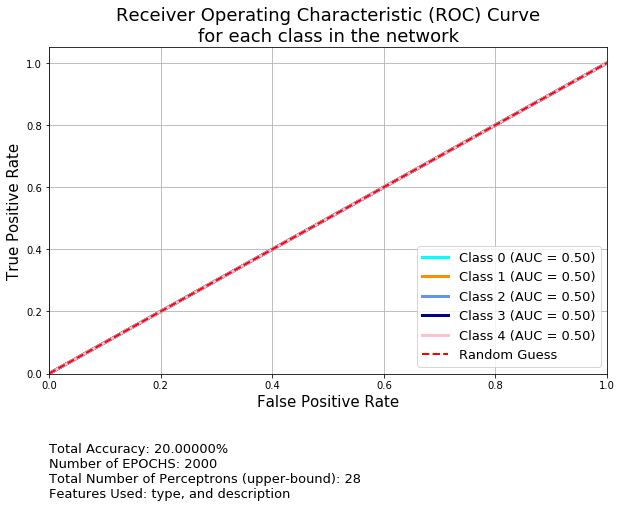


  >> Accuracy = 20.00000% vs. Random = 19.92308%
> Using  27  perceptrons and 1 hidden layer(s) ...
  EPOCH: 1000 Cost = 1.627922773361206
  EPOCH: 2000 Cost = 1.623151659965515


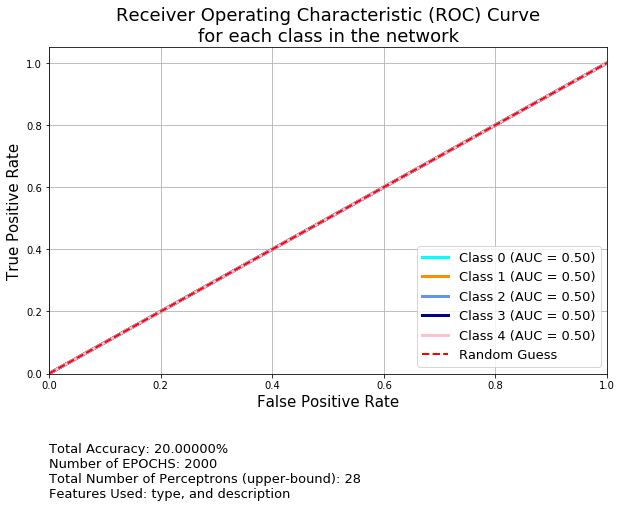


  >> Accuracy = 20.00000% vs. Random = 19.92308%


In [21]:
# run model
total_acc = run_model(n_hidden_layers, X, y, n, learning_rate, epochs, k, init_perceptrons,
                        total_perceptrons, step, feature_names)

# print(precision_recall_fscore)

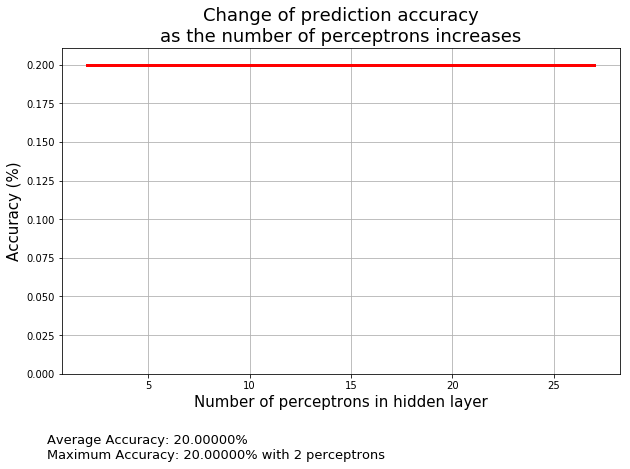

In [30]:
# plotting accuracy (only if the number of perceptrons varies)
if (init_perceptrons < total_perceptrons):
    
    perceptron_count = range(init_perceptrons, init_perceptrons + total_perceptrons + 1, step)
    
    avg_acc = np.mean(total_acc)

    max_acc_index = np.argmax(total_acc)
    max_acc = total_acc[max_acc_index]
    
    fig_caption = ("Average Accuracy: {:.5f}%".format(avg_acc*100) + "\nMaximum Accuracy: {:.5f}%".format(max_acc*100)
                   + " with " + str(perceptron_count[max_acc_index]) + " perceptrons")
    title= 'Change of prediction accuracy\nas the number of perceptrons increases'
    file_name = './results/accuracy-perceptrons-' + str(init_perceptrons) + '-to-' + str(total_perceptrons)

    plt.figure(figsize=(10, 6))
    plt.plot(perceptron_count, total_acc, lw=3, color='red')
    plt.title(title, fontsize=18)
    plt.xlabel("Number of perceptrons in hidden layer", fontsize=15)
    plt.ylabel("Accuracy (%)", fontsize=15)
    plt.grid()
    plt.ylim(ymin=0)
    plt.text(0, -0.055, fig_caption, fontsize=13)
    
    # if the file exists, don't overrite it. instead, add a number to the right.
    i = 1
    while os.path.exists('{}-({:d}).png'.format(file_name, i)):
        i += 1
    plt.savefig('{}-({:d}).png'.format(file_name, i))
    
    plt.show()